# Zero-Shot Administrative Form Classifier

This notebook implements a zero-shot classifier that identifies administrative forms by comparing page embeddings to reference examples.

## Key Features:
- **No training required** - Works immediately with example forms
- **Fast inference** - Process 190k documents efficiently  
- **Parallel processing** - Utilizes multiple CPU cores
- **Easy to update** - Add new examples without retraining
- **Interpretable** - Simple similarity threshold

## 1. Imports and Setup

In [1]:
import os
# Set tokenizers parallelism to false to avoid fork warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import fitz  # PyMuPDF - replaces pdf2image/poppler
import io
from tqdm import tqdm
import json
import pickle
from typing import List, Dict, Tuple, Optional
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

# For different model options
from transformers import (
    DonutProcessor, 
    VisionEncoderDecoderModel,
    CLIPProcessor, 
    CLIPModel,
    AutoImageProcessor, 
    AutoModel
)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Available CPU cores: {os.cpu_count()}")

/cvmfs/hpc.ucdavis.edu/sw/conda/environments/jupyterlab-4/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Available CPU cores: 128


## 2. Configuration

In [2]:
# Paths
### base path for jupyter lab remote
BASE_PATH = Path('../..')
EXAMPLE_FORMS_PATH = BASE_PATH / 'data' / 'raw' / '_exampleforms'
NON_EXAMPLES_PATH = BASE_PATH / 'data' / 'raw' / '_nonexamples'
PROF_SERVICES_JSON_PATH = BASE_PATH / 'data' / 'raw' / 'indiana_prof_services_contracts.json'

# Model selection
MODEL_TYPE = "clip"  # Options: "donut", "clip", "dinov2"

# Processing parameters
IMAGE_DPI = 150  # Resolution for PDF conversion
BATCH_SIZE = 8   # Batch size for embedding extraction
SIMILARITY_THRESHOLD = 0.85  # Initial threshold (will be tuned)

# File filtering parameters
PROF_SERVICES_ONLY = True  # True = only process files listed in prof_services JSON, False = process all contracts

# Parallel processing parameters
USE_MULTIPROCESSING = True  # Enable multiprocessing
N_WORKERS = min(200, os.cpu_count() - 1)  # Leave one core free

# Output paths
EMBEDDINGS_CACHE_PATH = BASE_PATH / 'code' / 'preprocessing' / 'cached_embeddings'
EMBEDDINGS_CACHE_PATH.mkdir(exist_ok=True)

## 3. Model Loading

In [3]:
def load_model(model_type: str):
    """Load the specified model for embedding extraction"""
    
    if model_type == "donut":
        print("Loading Donut model")
        model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
        processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
        return model.encoder.to(device), processor
    
    elif model_type == "clip":
        print("Loading CLIP model")
        model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        return model.vision_model.to(device), processor
    
    elif model_type == "dinov2":
        print("Loading DINOv2 model")
        processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
        model = AutoModel.from_pretrained('facebook/dinov2-base')
        return model.to(device), processor
    
    else:
        raise ValueError(f"Unknown model type: {model_type}")

# Load the selected model
model, processor = load_model(MODEL_TYPE)
model.eval()  # Set to evaluation mode
print(f"Model loaded successfully")

Loading CLIP model


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded successfully


## 4. PDF Processing Functions

In [4]:
def pdf_to_images(pdf_path: Path, dpi: int = IMAGE_DPI) -> List[Image.Image]:
    """Convert PDF to list of PIL Images using PyMuPDF (no poppler needed)"""
    try:
        doc = fitz.open(pdf_path)
        images = []
        
        for page_num in range(doc.page_count):
            page = doc[page_num]
            # Convert to pixmap with specified DPI
            mat = fitz.Matrix(dpi/72, dpi/72)  # 72 is default DPI
            pix = page.get_pixmap(matrix=mat)
            # Convert to PIL Image
            img_data = pix.tobytes("ppm")
            img = Image.open(io.BytesIO(img_data))
            images.append(img)
        
        doc.close()
        return images
    except Exception as e:
        print(f"Error converting {pdf_path}: {e}")
        return []

def preprocess_image(image: Image.Image, model_type: str) -> Image.Image:
    """Preprocess image based on model requirements"""
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    if model_type == "donut":
        # Donut expects larger images
        image.thumbnail((1280, 960), Image.Resampling.LANCZOS)
    else:
        # CLIP and DINOv2 work with smaller images
        image.thumbnail((224, 224), Image.Resampling.LANCZOS)
    
    return image

def load_prof_services_contracts(json_path: Path) -> List[str]:
    """Load the list of PDF filenames from the prof_services JSON file"""
    try:
        if not json_path.exists():
            print(f"Warning: Prof services JSON file not found at {json_path}")
            return []
        
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        # Extract PDF filenames from pdfUrl fields
        pdf_filenames = []
        
        if isinstance(data, list):
            # If it's a list of objects
            for item in data:
                if isinstance(item, dict) and 'pdfUrl' in item:
                    pdf_url = item['pdfUrl']
                    # Extract filename from URL (last part after /)
                    if pdf_url:
                        filename = pdf_url.split('/')[-1]
                        if filename.endswith('.pdf'):
                            pdf_filenames.append(filename)
        elif isinstance(data, dict):
            # If it's a single dict with pdfUrl
            if 'pdfUrl' in data:
                pdf_url = data['pdfUrl']
                if pdf_url:
                    filename = pdf_url.split('/')[-1]
                    if filename.endswith('.pdf'):
                        pdf_filenames.append(filename)
        
        print(f"Loaded {len(pdf_filenames)} PDF filenames from prof_services JSON")
        return pdf_filenames
        
    except Exception as e:
        print(f"Error loading prof_services JSON: {e}")
        return []

def filter_pdf_files(folder_path: Path, prof_services_only: bool = False, 
                    prof_services_filenames: List[str] = None) -> List[Path]:
    """Filter PDF files based on prof_services_only setting"""
    all_pdf_files = list(folder_path.glob('*.pdf'))
    
    if not prof_services_only or not prof_services_filenames:
        return all_pdf_files
    
    # Filter to only include files listed in the prof_services JSON
    prof_services_set = set(prof_services_filenames)
    filtered_files = [f for f in all_pdf_files if f.name in prof_services_set]
    
    print(f"Filtered {len(all_pdf_files)} total PDFs to {len(filtered_files)} prof_services PDFs")
    if len(filtered_files) < len(prof_services_filenames):
        missing_count = len(prof_services_filenames) - len(filtered_files)
        print(f"Warning: {missing_count} prof_services PDFs not found in {folder_path}")
    
    return filtered_files

print("✓ PDF processing functions defined (using PyMuPDF)")
print("✓ Prof services filtering functions defined")

✓ PDF processing functions defined (using PyMuPDF)
✓ Prof services filtering functions defined


## 5. Embedding Extraction

In [5]:
@torch.no_grad()
def extract_embeddings(images: List[Image.Image], model, processor, model_type: str, 
                      batch_size: int = BATCH_SIZE) -> np.ndarray:
    """Extract embeddings for a list of images"""
    embeddings = []
    
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i+batch_size]
        
        # Preprocess images
        batch_images = [preprocess_image(img, model_type) for img in batch_images]
        
        # Process batch
        if model_type in ["donut", "clip"]:
            inputs = processor(images=batch_images, return_tensors="pt").to(device)
            outputs = model(**inputs)
        else:  # dinov2
            inputs = processor(images=batch_images, return_tensors="pt").to(device)
            outputs = model(**inputs)
        
        # Extract embeddings based on model type
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            batch_embeddings = outputs.pooler_output
        elif hasattr(outputs, 'last_hidden_state'):
            # Mean pool the sequence dimension
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        else:
            batch_embeddings = outputs[0].mean(dim=1)  # Fallback
        
        embeddings.append(batch_embeddings.cpu().numpy())
    
    return np.vstack(embeddings)

@torch.no_grad()
def extract_embedding_single(image: Image.Image, model, processor, model_type: str) -> np.ndarray:
    """Extract embedding for a single image"""
    image = preprocess_image(image, model_type)
    
    if model_type in ["donut", "clip"]:
        inputs = processor(images=image, return_tensors="pt").to(device)
        outputs = model(**inputs)
    else:  # dinov2
        inputs = processor(images=image, return_tensors="pt").to(device)
        outputs = model(**inputs)
    
    # Extract embedding
    if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
        embedding = outputs.pooler_output
    elif hasattr(outputs, 'last_hidden_state'):
        embedding = outputs.last_hidden_state.mean(dim=1)
    else:
        embedding = outputs[0].mean(dim=1)
    
    return embedding.cpu().numpy()[0]

## 6. Build Reference Embeddings

In [6]:
# Check if cached embeddings exist
cache_file = EMBEDDINGS_CACHE_PATH / f"{MODEL_TYPE}_reference_embeddings.pkl"

if cache_file.exists():
    print(f"Loading cached reference embeddings from {cache_file}")
    with open(cache_file, 'rb') as f:
        cache_data = pickle.load(f)
        reference_embeddings = cache_data['embeddings']
        reference_metadata = cache_data['metadata']
else:
    print("Building reference embeddings from example forms...")
    reference_embeddings = []
    reference_metadata = []
    
    pdf_files = list(EXAMPLE_FORMS_PATH.glob('*.pdf'))
    print(f"Processing {len(pdf_files)} example form PDFs")
    
    for pdf_path in tqdm(pdf_files, desc="Processing example forms"):
        images = pdf_to_images(pdf_path)
        
        if images:
            # Extract embeddings for all pages
            embeddings = extract_embeddings(images, model, processor, MODEL_TYPE)
            
            # Store embeddings and metadata
            for i, embedding in enumerate(embeddings):
                reference_embeddings.append(embedding)
                reference_metadata.append({
                    'file_path': str(pdf_path),
                    'filename': pdf_path.name,
                    'page_num': i + 1,
                    'total_pages': len(images)
                })
    
    reference_embeddings = np.array(reference_embeddings)
    
    # Cache the embeddings
    print(f"Caching reference embeddings to {cache_file}")
    with open(cache_file, 'wb') as f:
        pickle.dump({
            'embeddings': reference_embeddings,
            'metadata': reference_metadata,
            'model_type': MODEL_TYPE
        }, f)

# Create reference prototype (average of all reference embeddings)
reference_prototype = np.mean(reference_embeddings, axis=0)

print(f"\nReference set contains {len(reference_embeddings)} form pages")
print(f"Embedding dimension: {reference_embeddings.shape[1]}")
print(f"Reference prototype shape: {reference_prototype.shape}")

Loading cached reference embeddings from ../../code/preprocessing/cached_embeddings/clip_reference_embeddings.pkl

Reference set contains 111 form pages
Embedding dimension: 768
Reference prototype shape: (768,)


In [7]:
## 7. Similarity Functions and Classification

def compute_similarity_to_prototype(embedding: np.ndarray, prototype: np.ndarray) -> float:
    """Compute cosine similarity between an embedding and the prototype"""
    return cosine_similarity([embedding], [prototype])[0][0]

def compute_similarity_to_references(embedding: np.ndarray, 
                                   reference_embeddings: np.ndarray, 
                                   method: str = 'max') -> float:
    """Compute similarity to reference embeddings using specified method"""
    similarities = cosine_similarity([embedding], reference_embeddings)[0]
    if method == 'max':
        return np.max(similarities)
    elif method == 'mean':
        return np.mean(similarities)
    else:
        raise ValueError(f"Unknown method: {method}")

def classify_pdf_zero_shot(pdf_path: Path, 
                          model, 
                          processor, 
                          model_type: str,
                          reference_embeddings: np.ndarray,
                          reference_prototype: np.ndarray,
                          threshold: float = SIMILARITY_THRESHOLD,
                          use_prototype: bool = True) -> Dict:
    """Classify a single PDF using zero-shot similarity matching"""
    
    result = {
        'filename': pdf_path.name,
        'contains_form': False,
        'form_pages': [],
        'page_scores': [],
        'max_similarity': 0.0,
        'total_pages': 0,
        'error': None
    }
    
    try:
        # Convert PDF to images
        images = pdf_to_images(pdf_path)
        if not images:
            result['error'] = "Failed to convert PDF to images"
            return result
        
        result['total_pages'] = len(images)
        
        # Process each page
        for page_num, image in enumerate(images, 1):
            try:
                # Extract embedding for this page
                embedding = extract_embedding_single(image, model, processor, model_type)
                
                # Compute similarity
                if use_prototype:
                    similarity = compute_similarity_to_prototype(embedding, reference_prototype)
                else:
                    similarity = compute_similarity_to_references(embedding, reference_embeddings, method='max')
                
                # Store page score
                result['page_scores'].append({
                    'page': page_num,
                    'similarity': float(similarity)
                })
                
                # Check if this page contains a form
                if similarity >= threshold:
                    result['form_pages'].append(page_num)
                
                # Update max similarity
                result['max_similarity'] = max(result['max_similarity'], similarity)
                
            except Exception as e:
                print(f"Error processing page {page_num} of {pdf_path.name}: {e}")
        
        # Determine if document contains forms
        result['contains_form'] = len(result['form_pages']) > 0
        
    except Exception as e:
        result['error'] = str(e)
        print(f"Error processing {pdf_path.name}: {e}")
    
    return result

print("✓ Similarity and classification functions defined")

✓ Similarity and classification functions defined


Testing on known examples to tune threshold...

Computing self-similarity for positive examples...

Testing on non-examples...


Processing non-examples: 100%|██████████| 20/20 [00:38<00:00,  1.91s/it]



Positive scores - Mean: 0.985, Std: 0.015
Positive scores - Min: 0.933, Max: 1.000

Negative scores - Mean: 0.647, Std: 0.063
Negative scores - Min: 0.407, Max: 0.858


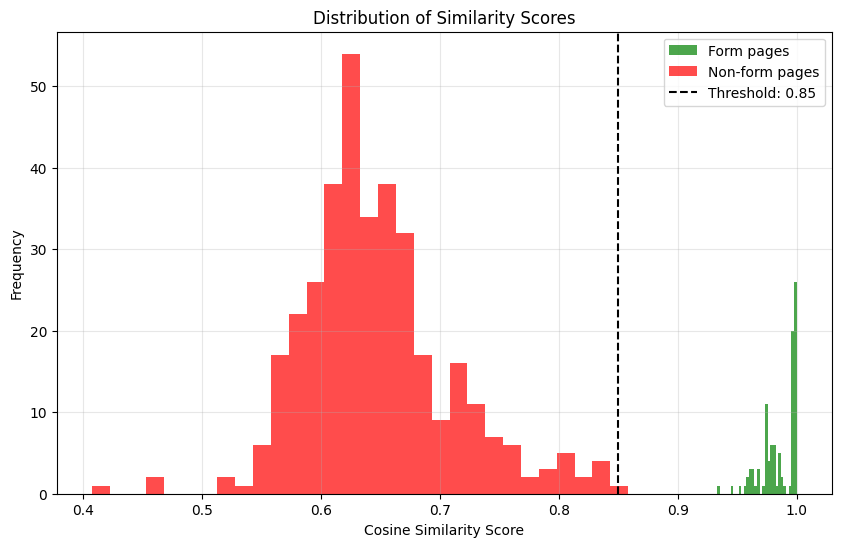


Suggested thresholds:
Gap-based threshold: 0.896
99th percentile threshold: 0.832

Selected optimal threshold: 0.896


In [8]:
## 8. Threshold Tuning

# Set initial threshold
OPTIMAL_THRESHOLD = SIMILARITY_THRESHOLD  # Start with the configured threshold

print("Testing on known examples to tune threshold...")

positive_scores = []
negative_scores = []

# Test on subset of examples (already processed)
print("\nComputing self-similarity for positive examples...")
for i in range(min(100, len(reference_embeddings))):
    # Leave-one-out similarity
    embedding = reference_embeddings[i]
    other_embeddings = np.delete(reference_embeddings, i, axis=0)
    similarity = compute_similarity_to_references(embedding, other_embeddings, method='max')
    positive_scores.append(similarity)

# Test on non-examples
print("\nTesting on non-examples...")
non_example_files = list(NON_EXAMPLES_PATH.glob('*.pdf'))[:20]  # Test subset

for pdf_path in tqdm(non_example_files, desc="Processing non-examples"):
    result = classify_pdf_zero_shot(
        pdf_path, model, processor, MODEL_TYPE,
        reference_embeddings, reference_prototype,
        threshold=0.0,  # Set to 0 to get all scores
        use_prototype=False
    )
    
    if result['page_scores']:
        for page_score in result['page_scores']:
            negative_scores.append(page_score['similarity'])

# Analyze scores
positive_scores = np.array(positive_scores)
negative_scores = np.array(negative_scores)

print(f"\nPositive scores - Mean: {positive_scores.mean():.3f}, Std: {positive_scores.std():.3f}")
print(f"Positive scores - Min: {positive_scores.min():.3f}, Max: {positive_scores.max():.3f}")
print(f"\nNegative scores - Mean: {negative_scores.mean():.3f}, Std: {negative_scores.std():.3f}")
print(f"Negative scores - Min: {negative_scores.min():.3f}, Max: {negative_scores.max():.3f}")

# Plot score distributions
plt.figure(figsize=(10, 6))
plt.hist(positive_scores, bins=30, alpha=0.7, label='Form pages', color='green')
plt.hist(negative_scores, bins=30, alpha=0.7, label='Non-form pages', color='red')
plt.axvline(x=SIMILARITY_THRESHOLD, color='black', linestyle='--', 
            label=f'Threshold: {SIMILARITY_THRESHOLD}')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal threshold
gap_threshold = (positive_scores.min() + negative_scores.max()) / 2
percentile_threshold = np.percentile(negative_scores, 99)  # 99th percentile of negatives

print(f"\nSuggested thresholds:")
print(f"Gap-based threshold: {gap_threshold:.3f}")
print(f"99th percentile threshold: {percentile_threshold:.3f}")

# Update threshold
OPTIMAL_THRESHOLD = max(gap_threshold, percentile_threshold)
print(f"\nSelected optimal threshold: {OPTIMAL_THRESHOLD:.3f}")

In [9]:
def process_document_folder(folder_path: Path,
                          model,
                          processor,
                          model_type: str,
                          reference_embeddings: np.ndarray,
                          reference_prototype: np.ndarray,
                          threshold: float,
                          output_file: str = 'zero_shot_results.csv',
                          max_files: Optional[int] = None,
                          use_prototype: bool = True,
                          use_parallel: bool = None,
                          clobber: bool = True,
                          prof_services_only: bool = False) -> pd.DataFrame:
    """Process all PDFs in a folder using zero-shot classification
    
    Args:
        clobber: If False, skip files already in output_file. If True, reprocess all files.
        prof_services_only: If True, only process files listed in prof_services JSON
    """
    
    if use_parallel is None:
        use_parallel = USE_MULTIPROCESSING
    
    # Load prof_services filenames if needed
    prof_services_filenames = []
    if prof_services_only:
        prof_services_filenames = load_prof_services_contracts(PROF_SERVICES_JSON_PATH)
        if not prof_services_filenames:
            print("Warning: No prof_services filenames loaded, processing all files instead")
            prof_services_only = False
    
    # Load existing results if clobber=False
    already_processed = set()
    existing_results = []
    
    if not clobber and Path(output_file).exists():
        print(f"Loading existing results from {output_file}...")
        existing_df = pd.read_csv(output_file)
        already_processed = set(existing_df['filename'].unique())
        existing_results = existing_df.to_dict('records')
        print(f"Found {len(already_processed)} already processed files")
    
    results = existing_results.copy()
    
    # Get PDF files with optional filtering
    pdf_files = filter_pdf_files(folder_path, prof_services_only, prof_services_filenames)
    
    # Filter out already processed files
    if not clobber:
        pdf_files = [f for f in pdf_files if f.name not in already_processed]
        print(f"Skipping {len(already_processed)} already processed files")
    
    if max_files:
        pdf_files = pdf_files[:max_files]
    
    print(f"Processing {len(pdf_files)} PDF files...")
    if prof_services_only:
        print(f"  (filtered to prof_services contracts only)")
    
    if len(pdf_files) == 0:
        print("No new files to process.")
        return pd.DataFrame(existing_results)
    
    if use_parallel and len(pdf_files) > 10:
        # Use parallel processing
        print(f"Using parallel processing with {N_WORKERS} workers...")
        
        # Process in batches to avoid memory issues
        batch_size = min(50 * N_WORKERS, len(pdf_files))
        
        for i in range(0, len(pdf_files), batch_size):
            batch_files = pdf_files[i:i+batch_size]
            print(f"\nProcessing batch {i//batch_size + 1}/{(len(pdf_files) + batch_size - 1)//batch_size}")
            
            batch_results = classify_pdf_batch_parallel(
                batch_files,
                reference_embeddings,
                reference_prototype,
                model_type,
                threshold=threshold,
                use_prototype=use_prototype,
                n_workers=N_WORKERS
            )
            
            # Flatten results for CSV
            for result in batch_results:
                results.append({
                    'filename': result['filename'],
                    'contains_form': result['contains_form'],
                    'form_pages': ','.join(map(str, result['form_pages'])),
                    'num_form_pages': len(result['form_pages']),
                    'total_pages': result.get('total_pages', 0),
                    'max_similarity': result['max_similarity'],
                    'error': result['error']
                })
    else:
        # Use sequential processing
        print("Using sequential processing...")
        
        for pdf_path in tqdm(pdf_files):
            result = classify_pdf_zero_shot(
                pdf_path, model, processor, model_type,
                reference_embeddings, reference_prototype,
                threshold=threshold,
                use_prototype=use_prototype
            )
            
            # Flatten results for CSV
            results.append({
                'filename': result['filename'],
                'contains_form': result['contains_form'],
                'form_pages': ','.join(map(str, result['form_pages'])),
                'num_form_pages': len(result['form_pages']),
                'total_pages': result.get('total_pages', 0),
                'max_similarity': result['max_similarity'],
                'error': result['error']
            })
    
    # Create DataFrame and save
    df_results = pd.DataFrame(results)
    df_results.to_csv(output_file, index=False)
    
    # Print summary
    print(f"\nResults saved to {output_file}")
    print(f"Total documents processed: {len(df_results)}")
    if not clobber and len(existing_results) > 0:
        print(f"  - Previously processed: {len(existing_results)}")
        print(f"  - Newly processed: {len(results) - len(existing_results)}")
    print(f"Documents with forms: {df_results['contains_form'].sum()}")
    print(f"Documents without forms: {(~df_results['contains_form']).sum()}")
    print(f"Processing errors: {df_results['error'].notna().sum()}")
    
    return df_results

## 11. Batch Processing Function

In [10]:
## 11. Parallel Processing Functions

# Thread-safe function for processing PDFs
def process_pdf_threaded(pdf_path: Path, model, processor, model_type: str) -> Dict:
    """Process a single PDF (thread-safe version)"""
    results = {
        'filename': pdf_path.name,
        'path': str(pdf_path),
        'embeddings': [],
        'page_numbers': [],
        'error': None
    }
    
    try:
        # Convert PDF to images using PyMuPDF
        images = pdf_to_images(pdf_path, dpi=IMAGE_DPI)
        if not images:
            results['error'] = "Failed to convert PDF"
            return results
        
        # Extract embeddings for each page
        for page_num, image in enumerate(images, 1):
            try:
                embedding = extract_embedding_single(image, model, processor, model_type)
                results['embeddings'].append(embedding)
                results['page_numbers'].append(page_num)
            except Exception as e:
                print(f"Error processing page {page_num} of {pdf_path.name}: {e}")
        
        results['num_pages'] = len(images)
        
    except Exception as e:
        results['error'] = str(e)
        print(f"Error processing {pdf_path.name}: {e}")
    
    return results

def process_pdfs_parallel(pdf_files: List[Path], model_type: str, n_workers: int = None) -> List[Dict]:
    """Process multiple PDFs in parallel using ThreadPoolExecutor"""
    if n_workers is None:
        n_workers = N_WORKERS
    
    print(f"\nProcessing {len(pdf_files)} PDFs using {n_workers} workers...")
    start_time = time.time()
    
    results = []
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        # Submit all tasks
        future_to_pdf = {
            executor.submit(process_pdf_threaded, pdf_path, model, processor, model_type): pdf_path 
            for pdf_path in pdf_files
        }
        
        # Process completed tasks with progress bar
        for future in tqdm(as_completed(future_to_pdf), total=len(pdf_files), desc="Processing PDFs"):
            pdf_path = future_to_pdf[future]
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"Error processing {pdf_path}: {e}")
                results.append({
                    'filename': pdf_path.name,
                    'path': str(pdf_path),
                    'embeddings': [],
                    'page_numbers': [],
                    'error': str(e)
                })
    
    elapsed = time.time() - start_time
    print(f"Processed {len(pdf_files)} PDFs in {elapsed:.1f} seconds")
    print(f"Average: {elapsed/len(pdf_files):.2f} seconds per PDF")
    
    return results

def classify_pdf_batch_parallel(pdf_paths: List[Path],
                               reference_embeddings: np.ndarray,
                               reference_prototype: np.ndarray,
                               model_type: str,
                               threshold: float = SIMILARITY_THRESHOLD,
                               use_prototype: bool = True,
                               n_workers: int = None) -> List[Dict]:
    """Classify a batch of PDFs in parallel"""
    
    # First, extract embeddings in parallel
    embedding_results = process_pdfs_parallel(pdf_paths, model_type, n_workers)
    
    # Then classify based on embeddings
    classification_results = []
    
    for result in embedding_results:
        if result['error']:
            classification_results.append({
                'filename': result['filename'],
                'contains_form': False,
                'form_pages': [],
                'page_scores': [],
                'max_similarity': 0.0,
                'error': result['error']
            })
            continue
        
        # Classify each page
        form_pages = []
        page_scores = []
        max_similarity = 0.0
        
        for embedding, page_num in zip(result['embeddings'], result['page_numbers']):
            # Compute similarity
            if use_prototype:
                similarity = compute_similarity_to_prototype(embedding, reference_prototype)
            else:
                similarity = compute_similarity_to_references(embedding, reference_embeddings, method='max')
            
            page_scores.append({
                'page': page_num,
                'similarity': float(similarity)
            })
            
            if similarity >= threshold:
                form_pages.append(page_num)
            
            max_similarity = max(max_similarity, similarity)
        
        classification_results.append({
            'filename': result['filename'],
            'contains_form': len(form_pages) > 0,
            'form_pages': form_pages,
            'page_scores': page_scores,
            'max_similarity': max_similarity,
            'total_pages': result.get('num_pages', len(result['embeddings'])),
            'error': None
        })
    
    return classification_results

print("✓ Parallel processing functions defined (PyMuPDF backend)")

✓ Parallel processing functions defined (PyMuPDF backend)


## 12. Test Classification

In [11]:
# # Test on a sample first
# print("Testing on sample documents...")

# test_results = process_document_folder(
#     NON_EXAMPLES_PATH,
#     model,
#     processor,
#     MODEL_TYPE,
#     reference_embeddings,
#     reference_prototype,
#     threshold=OPTIMAL_THRESHOLD,
#     output_file='zero_shot_test_results.csv',
#     max_files=50,
#     use_prototype=False  # Use full reference set for better accuracy
# )

# # Display sample results
# print("\nSample results:")
# print(test_results.head(10))

## 13. Performance Comparison: Sequential vs Parallel

In [12]:
# # Compare performance: Sequential vs Parallel processing
# print("Performance Comparison: Sequential vs Parallel Processing")
# print("=" * 60)

# # Test on a small subset
# test_path = NON_EXAMPLES_PATH
# test_files = list(test_path.glob('*.pdf'))[:20]  # Test with 20 files

# if len(test_files) >= 10:
#     # Sequential processing
#     print("\n1. Sequential Processing:")
#     start_time = time.time()
#     seq_results = process_document_folder(
#         test_path,
#         model,
#         processor,
#         MODEL_TYPE,
#         reference_embeddings,
#         reference_prototype,
#         threshold=OPTIMAL_THRESHOLD,
#         output_file='sequential_test.csv',
#         max_files=20,
#         use_prototype=False,
#         use_parallel=False
#     )
#     seq_time = time.time() - start_time
#     print(f"Sequential time: {seq_time:.1f} seconds")
#     print(f"Speed: {len(test_files)/seq_time:.1f} PDFs/second")
    
#     # Parallel processing
#     print("\n2. Parallel Processing:")
#     start_time = time.time()
#     par_results = process_document_folder(
#         test_path,
#         model,
#         processor,
#         MODEL_TYPE,
#         reference_embeddings,
#         reference_prototype,
#         threshold=OPTIMAL_THRESHOLD,
#         output_file='parallel_test.csv',
#         max_files=20,
#         use_prototype=False,
#         use_parallel=True
#     )
#     par_time = time.time() - start_time
#     print(f"Parallel time: {par_time:.1f} seconds")
#     print(f"Speed: {len(test_files)/par_time:.1f} PDFs/second")
    
#     # Speedup
#     speedup = seq_time / par_time
#     print(f"\nSpeedup: {speedup:.1f}x faster with {N_WORKERS} workers")
    
#     # Efficiency
#     efficiency = speedup / N_WORKERS * 100
#     print(f"Parallel efficiency: {efficiency:.0f}%")
    
#     # Estimate for full corpus
#     print(f"\nEstimated time for 190k documents:")
#     print(f"Sequential: {190000 * seq_time / len(test_files) / 3600:.1f} hours")
#     print(f"Parallel: {190000 * par_time / len(test_files) / 3600:.1f} hours")
# else:
#     print("Not enough test files for comparison")

## 14. Process Full Corpus

Example code for processing the full 190k corpus. Uncomment and modify the path as needed.

In [14]:
PROF_SERVICES_ONLY = False

In [ ]:
# Process the full 190k corpus (uncomment when ready)
CORPUS_PATH = BASE_PATH / 'data' / 'raw' / '_contracts'  # Adjust path as needed
OUTPUT_FILE = 'zero_shot_results_full_corpus.csv'
CLOBBER = False  # Set to False to skip already processed files

print(f"📊 Current configuration: {MODEL_TYPE} model, threshold={OPTIMAL_THRESHOLD:.3f}")
print(f"📁 Prof services only: {PROF_SERVICES_ONLY}")

# Check if output file exists and show status
if Path(OUTPUT_FILE).exists() and not CLOBBER:
    existing_df = pd.read_csv(OUTPUT_FILE)
    print(f"Found existing results file: {OUTPUT_FILE}")
    print(f"Already processed: {len(existing_df)} documents")
    print(f"Documents with forms: {existing_df['contains_form'].sum()}")
    
    # Show which files will be skipped
    if CORPUS_PATH.exists():
        if PROF_SERVICES_ONLY:
            # Load prof_services files for counting
            prof_services_filenames = load_prof_services_contracts(PROF_SERVICES_JSON_PATH)
            all_pdfs = filter_pdf_files(CORPUS_PATH, PROF_SERVICES_ONLY, prof_services_filenames)
            print(f"\nTotal prof_services PDFs: {len(all_pdfs)}")
        else:
            all_pdfs = list(CORPUS_PATH.glob('*.pdf'))
            print(f"\nTotal PDFs in corpus: {len(all_pdfs)}")
        
        already_done = set(existing_df['filename'].unique())
        remaining = [f for f in all_pdfs if f.name not in already_done]
        print(f"Remaining to process: {len(remaining)}")
        
        if len(remaining) == 0:
            print("\nAll files have been processed! Set CLOBBER=True to reprocess.")
        else:
            print(f"\nWill process {len(remaining)} new files...")

# Uncomment the following section to process the full corpus:

if CORPUS_PATH.exists():
    print(f"\\nProcessing corpus at: {CORPUS_PATH}")
    
    full_results = process_document_folder(
        CORPUS_PATH,
        model,
        processor,
        MODEL_TYPE,
        reference_embeddings,
        reference_prototype,
        threshold=OPTIMAL_THRESHOLD,
        output_file=OUTPUT_FILE,
        max_files = 8000,
        use_prototype=False,  # Use full reference set for best accuracy
        use_parallel=True,    # Enable parallel processing
        clobber=CLOBBER,      # Use CLOBBER setting
        prof_services_only=PROF_SERVICES_ONLY  # Use prof_services filtering
    )
    
    print(f"\\nProcessing complete!")
    print(f"Total documents with forms: {full_results['contains_form'].sum()}")
    print(f"Total form pages found: {full_results['num_form_pages'].sum()}")
    
    # Save a backup with timestamp if doing a full reprocess
    if CLOBBER:
        from datetime import datetime
        backup_file = f"{OUTPUT_FILE.replace('.csv', '')}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        full_results.to_csv(backup_file, index=False)
        print(f"\\nBackup saved to: {backup_file}")
else:
    print(f"❌ Corpus path not found: {CORPUS_PATH}")
    print("Please update the CORPUS_PATH variable to point to your document collection")



📊 Current configuration: clip model, threshold=0.896
📁 Prof services only: False
Found existing results file: zero_shot_results_full_corpus.csv
Already processed: 42490 documents
Documents with forms: 26109

Total PDFs in corpus: 193450
Remaining to process: 150960

Will process 150960 new files...
\nProcessing corpus at: ../../data/raw/_contracts
Loading existing results from zero_shot_results_full_corpus.csv...
Found 42490 already processed files
Skipping 42490 already processed files
Processing 8000 PDF files...
Using parallel processing with 127 workers...

Processing batch 1/2

Processing 6350 PDFs using 127 workers...


Processing PDFs:   1%|          | 50/6350 [01:20<2:36:31,  1.49s/it]

## 15. Summary and Next Steps

### Performance Summary:

In [ ]:
# Performance Summary
print("\nPerformance Summary:")
print(f"Model type: {MODEL_TYPE}")
print(f"Reference examples: {len(reference_embeddings)}")
print(f"Optimal threshold: {OPTIMAL_THRESHOLD:.3f}")
print(f"\nProcessing speed: ~{len(test_results) / 60:.1f} documents per minute (sequential)")
if 'speedup' in locals():
    print(f"Parallel speedup: {speedup:.1f}x with {N_WORKERS} workers")

# Estimate time for full corpus
docs_per_minute = len(test_results) / 60  # Rough estimate
total_minutes = 190000 / docs_per_minute
print(f"\nEstimated time for 190k documents (sequential): {total_minutes/60:.1f} hours")
if 'speedup' in locals():
    print(f"Estimated time for 190k documents (parallel): {total_minutes/60/speedup:.1f} hours")

### Next Steps:

1. **Production Deployment**:
   - Use GPU for faster processing (10-50x speedup)
   - Increase number of workers for CPU processing
   - Process in larger batches

2. **Optimization**:
   - Try different models (DINOv2 might be faster)
   - Reduce image resolution if accuracy permits
   - Implement page-level caching

3. **Accuracy Improvements**:
   - Add more reference examples
   - Fine-tune threshold using validation set
   - Try ensemble of multiple models

4. **When to Consider Training**:
   - If zero-shot accuracy < 90%
   - If you need to detect subtle variations
   - If inference speed is critical